In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
from tensorflow.keras import layers
from tqdm import tqdm
import matplotlib.pyplot as plt
import pathlib
import os
import random

AUTOTUNE = tf.data.experimental.AUTOTUNE
tf.keras.backend.clear_session()  # For easy reset of notebook state.

tf.__version__
#tf.executing_eagerly()


'2.2.0'

In [2]:

ds = tfds.load(name="imagenette", with_info=True, split=["train[:20%]","validation[:20%]"])
ds_train=ds[0][0]
ds_test=ds[0][1]
assert isinstance(ds_train, tf.data.Dataset)

def normalize(x):
    y = {'image': tf.image.convert_image_dtype(x['image'], tf.float32), 'label': x['label']}
    y = (tf.image.resize(y['image'], (224,224)), y['label'])
    return y
    
ds_train = ds_train.map(lambda x: normalize(x))
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(100)
ds_train = ds_train.batch(64)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(
    normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(64)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [12]:
def unroll(tensor, shape):
    return tf.transpose(tf.reshape(tensor, shape))

def roll_back(tensor, shape):
    return(tf.reshape(tf.transpose(tensor), shape))

In [3]:
shape=(50176,3)
y = unroll(x, shape)
print(y.shape)
shape=(224,224,3)
z = roll_back(y, shape)
print(z.shape)
plt.figure()
plt.imshow(z)
plt.show()

NameError: name 'unroll' is not defined

tf.Tensor(9, shape=(), dtype=int64)
(224, 224, 3)


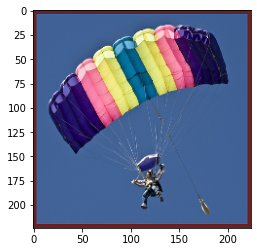

In [4]:
for z in ds_test.take(1):
    print(z[1][0])
    print(z[0][0].shape)
    x = z[0][0].numpy()
    tf.reshape
    plt.figure()
    plt.imshow(x)
    plt.show()

In [3]:

#conv2D with bias and relu activation

class CustomConvLayer(layers.Layer):

#    def __init__(self, weights, mask, biases, stride=1, padding='SAME'):
    def __init__(self, input_channels, output_channels, filter_size=3, stride=1, padding='SAME'):
        
        super(CustomConvLayer, self).__init__()
        self.w = self.add_weight(
            shape=(filter_size, filter_size, input_channels, output_channels),
            initializer='glorot_uniform',
            trainable=True,
            name='w'
        )
        self.m = self.add_weight(
            shape=(filter_size, filter_size, input_channels, output_channels),
            initializer='ones',
            trainable=False,
            name='m'
        )
        #self.b = self.add_weight(
        #    shape=(output_channels),
        #    initializer='zeros',
        #    trainable=True,
        #    name='b'
        #)
        self.s = stride
        self.p = padding

        
    def call(self, inputs):
        #print(inputs.shape)
        x = tf.nn.conv2d(inputs, tf.multiply(self.w, self.m), strides=[1, self.s, self.s, 1], padding=self.p)
        #x = tf.nn.bias_add(x, self.b)
        return tf.nn.relu(x)
    



    
class ResNetBlock(tf.keras.layers.Layer):
    def __init__(self, input_channels=3 ,output_channels = 64, stride=1):
        super(ResNetBlock, self).__init__()
        self.stride = stride
        #self.conv1 = layers.Conv2D(filters, 3, strides=(self.stride, self.stride), activation='relu', padding='same')
        self.conv1 = CustomConvLayer(input_channels, output_channels, filter_size=3)
        self.bn1 = layers.BatchNormalization()
        #self.conv2 = layers.Conv2D(filters, 3, padding='same')
        self.conv2 = CustomConvLayer(output_channels, output_channels, filter_size=3)
        self.bn2 = layers.BatchNormalization()
        if stride == 2:
            self.conv3 = CustomConvLayer(output_channels, output_channels, filter_size=1, stride=self.stride)
            self.bn3 = layers.BatchNormalization()
        self.add1 = layers.Add()
    
    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        if self.stride == 2:
            inputs = self.conv3(x)
            inputs = self.bn3(x)
        return tf.nn.relu(self.add1([x, inputs]))
    
#Dense Layer with Bias
class CustomDenseLayer(layers.Layer):
    
    def __init__(self, input_shape, output_shape, activation = 'relu'):
        super(CustomDenseLayer, self).__init__()
        self.w = self.add_weight(
            shape=(input_shape, output_shape),
            initializer='glorot_uniform',
            trainable=True,
            name='w'
        )
        self.m = self.add_weight(
            shape=(input_shape, output_shape),
            initializer='ones',
            trainable=False,
            name='m'
        )
        self.b = self.add_weight(
            shape=(output_shape),
            initializer='zeros',
            trainable=True,
            name='b'
        )
        self.a = activation
        
        
    def call(self, inputs):
        #print('dense w',self.w)
        #print('dense i',inputs)
        x = tf.matmul(inputs, tf.multiply(self.w, self.m))
        #print('dense x',x)
        x = tf.nn.bias_add(x, self.b)
        if self.a == 'relu':
            return tf.nn.relu(x)
        if self.a == 'softmax':
            return tf.nn.softmax(x)
    

class CustomResNetModel(tf.keras.Model):
    def __init__(self):
        super(CustomResNetModel, self).__init__()
        #self.conv1 = layers.Conv2D(64, 7, strides=(2, 2), padding='same')
        self.conv1 = CustomConvLayer(3, 64, filter_size=7, stride=2)
        self.pool1 = layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')
        self.res_block1 = ResNetBlock(64, 64)
        #self.res_block2 = ResNetBlock(64, 64)
        self.res_block3 = ResNetBlock(64, 64)
        self.res_block4 = ResNetBlock(64, 128, 2)
        #self.res_block5 = ResNetBlock(128, 128)
        #self.res_block6 = ResNetBlock(128, 128)
        self.res_block7 = ResNetBlock(128, 128)
        self.res_block8 = ResNetBlock(128, 256, 2)
        #self.res_block9 = ResNetBlock(256, 256)
        #self.res_block10 = ResNetBlock(256, 256)
        #self.res_block11 = ResNetBlock(256, 256)
        #self.res_block12 = ResNetBlock(256, 256)
        self.res_block13 = ResNetBlock(256, 256)
        self.res_block14 = ResNetBlock(256 ,512, 2)
        #self.res_block15 = ResNetBlock(512, 512)
        self.res_block16 = ResNetBlock(512, 512)
        self.pool2 = layers.GlobalAveragePooling2D()
        self.dense1 = CustomDenseLayer(512, 1000)
        self.dense2 = CustomDenseLayer(1000, 10, activation='softmax')
        #self.conv_layers = []
        #self.conv_masks = []
        #self.dense_layers = []
        #self.dense_masks = []
        self.conv_layers = [0, 2, 5, 14, 17, 26, 29, 44, 47, 56, 59, 74, 77, 86, 89, 104, 107]
        self.conv_masks = [1, 8, 11, 20, 23, 35, 38, 50, 53, 65, 68, 80, 83, 95, 98, 110, 113]
        self.dense_layers = [116, 119]
        self.dense_masks = [118, 121]
        


        
        
    def call(self,inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.res_block1(x)
        #x = self.res_block2(x)
        x = self.res_block3(x)
        x = self.res_block4(x)
        #x = self.res_block5(x)
        #x = self.res_block6(x)
        x = self.res_block7(x)
        x = self.res_block8(x)
        #x = self.res_block9(x)
        #x = self.res_block10(x)
        #x = self.res_block11(x)
        #x = self.res_block12(x)
        x = self.res_block13(x)
        x = self.res_block14(x)
        #x = self.res_block15(x)
        x = self.res_block16(x)
        x = self.pool2(x)
        x = self.dense1(x)
        
        return self.dense2(x)
    
    def prune_random_local_unstruct(self, ratio):
        def prune_conv_layers_locally(self, ratio):
            weights = self.get_weights()
            for i, layer in enumerate(self.conv_layers):
                converted_weights = convert_from_hwio_to_iohw(weights[layer]).numpy()
                converted_mask = convert_from_hwio_to_iohw(weights[self.conv_masks[i]]).numpy()
                for input_index, input_layer in enumerate(converted_weights):
                    for kernel_index, kernel in enumerate(input_layer):
                        shape = kernel.shape
                        flat_weights = kernel.flatten()
                        flat_masks = converted_mask[input_index][kernel_index].flatten()
                        
                        no_of_weighs_to_prune = ratio * len(flat_weights)
                        # find unpruned weights
                        non_zero_weights = np.nonzero(flat_masks)[0]
                        # calculate the amount of weights to be pruned this round
                        no_of_weights_to_prune_left = int(no_of_weighs_to_prune - (len(flat_weights) - len(non_zero_weights)) )
                        # shuffle all non-zero weights
                        random.shuffle(non_zero_weights)
                        # and take the indices of the first x weights where x is the number of weights to be pruned this round
                        indices_to_delete = non_zero_weights[:no_of_weights_to_prune_left]
                        
                        for idx_to_delete in indices_to_delete:
                            flat_masks[idx_to_delete] = 0
                            flat_weights[idx_to_delete] = 0
                        converted_mask[input_index][kernel_index] = flat_masks.reshape(shape)
                        converted_weights[input_index][kernel_index] = flat_weights.reshape(shape)
                back_converted_mask = convert_from_iohw_to_hwio(converted_mask)
                back_converted_weights = convert_from_iohw_to_hwio(converted_weights)
                weights[layer] = back_converted_weights
                weights[self.conv_masks[i]] = back_converted_mask
            self.set_weights(weights)
            return True
        
        def prune_dense_layers_locally(self, ratio):
            weights = self.get_weights()
#            for index, weight in enumerate(weights):
            for i, layer in enumerate(self.dense_layers):
#                if index in dense_layer_to_prune:
                    shape = weights[layer].shape
                    flat_weights = weights[layer].flatten()
                    flat_mask = weights[self.dense_masks[i]].flatten()
                    no_of_weighs_to_prune = ratio * len(flat_weights)
                    # find unpruned weights
                    non_zero_weights = np.nonzero(flat_mask)[0]
                    # calculate the amount of weights to be pruned this round
                    no_of_weights_to_prune_left = int(no_of_weighs_to_prune - (len(flat_weights) - len(non_zero_weights)) )
                    # shuffle all non-zero weights
                    random.shuffle(non_zero_weights)
                    # and take the indices of the first x weights where x is the number of weights to be pruned this round
                    indices_to_delete = non_zero_weights[:no_of_weights_to_prune_left]
                    for idx_to_delete in indices_to_delete:
                        flat_mask[idx_to_delete] = 0
                        flat_weights[idx_to_delete] = 0

                    mask_reshaped = flat_mask.reshape(shape)
                    weights_reshaped = flat_weights.reshape(shape)
                    weights[self.dense_masks[i]] = mask_reshaped
                    weights[i] = weights_reshaped
            #self.set_weights(weights)
            return weights
        weights = prune_conv_layers_locally(self, ratio)
        weights = prune_dense_layers_locally(self,ratio)
        return True
    
    def prune_magnitude_global_unstruct(self, ratio):

        weights = self.get_weights()
        flat_weights = []
        flat_mask = []
        all_masks = self.conv_masks + self.dense_masks
        for i, x in enumerate(self.conv_layers + self.dense_layers):
            flat_weights = np.append(flat_weights, weights[x])
            flat_mask = np.append(flat_mask, weights[all_masks[i]])
            
        no_of_weights_to_prune = int(len(flat_weights)*ratio)
        indices_to_delete = np.abs(flat_weights).argsort(0)[:no_of_weights_to_prune]
        
        for idx_to_delete in indices_to_delete:
            flat_mask[idx_to_delete] = 0
            flat_weights[idx_to_delete] = 0
        z = 0
        for i, x in enumerate(self.to_prune + self.dense_layer):
            weights[x] = flat_weights[z:z + np.prod(weights[x].shape)].reshape(weights[x].shape)
            weights[all_masks[i]] = flat_mask[z:z + np.prod(weights[x].shape)].reshape(weights[x].shape)
            z = z + np.prod(weights[x].shape)            
        self.set_weights(weights)
        return True
    
    
    def prune_random_local_struct(self, ratio):
        def prune_conv_layers(self, ratio):
            weights = self.get_weights()
            for i, x in enumerate(self.conv_layers):

                vals = []
                iohw_weights = convert_from_hwio_to_iohw(weights[x])
                iohw_mask = convert_from_hwio_to_iohw(weights[x+2])
                converted_shape = iohw_weights.shape
                no_of_channels = converted_shape[0]*converted_shape[1]
                no_of_channels_to_prune = int(np.round(ratio * no_of_channels))
                channels = tf.reshape(iohw_weights, (no_of_channels,converted_shape[2],converted_shape[3])).numpy()
                #print(channels)
                non_zero_channels = np.nonzero([np.sum(channel) for channel in channels])[0]
                #print(non_zero_channels)
                no_of_channels_to_prune_left = no_of_channels_to_prune - (len(channels) - len(non_zero_channels))
                random.shuffle(non_zero_channels)
                channels_to_prune = non_zero_channels[:no_of_channels_to_prune_left]
                mask = tf.reshape(iohw_mask, (no_of_channels,converted_shape[2],converted_shape[3])).numpy()

                for channel_to_prune in channels_to_prune:
                    channels[channel_to_prune] = tf.zeros([converted_shape[2],converted_shape[3]])
                    mask[channel_to_prune] = tf.zeros([converted_shape[2],converted_shape[3]])

                reshaped_mask = tf.reshape(mask, converted_shape)
                reshaped_weights = tf.reshape(channels, converted_shape)
                weights[x] = convert_from_iohw_to_hwio(reshaped_weights)
                weights[self.conv_masks[i]] = convert_from_iohw_to_hwio(reshaped_mask)
            #self.set_weights(weights)
            return True
        def prune_dense_layers(self, ratio):
            weights = self.get_weights()
            for i, layer_to_prune in enumerate(self.dense_layers):
                rows = weights[layer_to_prune]
                no_of_rows_to_prune = int(ratio * len(weights[layer_to_prune]))
                non_zero_rows = np.nonzero([np.sum(row) for row in rows])[0]
                no_of_rows_to_prune_left = no_of_rows_to_prune - (len(rows) - len(non_zero_rows))
                random.shuffle(non_zero_rows)
                rows_to_prune = non_zero_rows[:no_of_rows_to_prune_left]
                
                for row_to_prune in rows_to_prune:
                    weights[layer_to_prune][row_to_prune] = tf.zeros(len(weights[layer_to_prune][row_to_prune]))
                    weights[self.dense_masks[i]][row_to_prune] = tf.zeros(len(weights[layer_to_prune][row_to_prune]))
            return True
        prune_conv_layers(self, ratio)
        prune_dense_layers(self, ratio)
        self.set_weights(weights)
        return True

    def prune_random_global_struct(self, ratio):
        raise Warning('Not yet implemented')
        return False
    
    def prune_magnitude_local_struct(self, ratio):
        def prune_conv_layers(self, ratio):
            weights = self.get_weights()
            for i, x in enumerate(self.conv_layers):
                vals = []
                iohw_weights = convert_from_hwio_to_iohw(weights[x])
                iohw_mask = convert_from_hwio_to_iohw(self.conv_masks[i])
                converted_shape = iohw_weights.shape
                no_of_channels = converted_shape[0]*converted_shape[1]
                no_of_channels_to_prune = int(np.round(ratio * no_of_channels))
                channels = tf.reshape(iohw_weights, (no_of_channels,converted_shape[2],converted_shape[3])).numpy()
                
                mask = tf.reshape(iohw_mask, (no_of_channels,converted_shape[2],converted_shape[3])).numpy()
                for channel in channels:
                    vals.append(tf.math.reduce_sum(tf.math.abs(channel)))
                channels_to_prune = np.argsort(vals)[:no_of_channels_to_prune]

                for channel_to_prune in channels_to_prune:
                    channels[channel_to_prune] = tf.zeros([converted_shape[2],converted_shape[3]])
                    mask[channel_to_prune] = tf.zeros([converted_shape[2],converted_shape[3]])

                reshaped_mask = tf.reshape(mask, converted_shape)
                reshaped_weights = tf.reshape(channels, converted_shape)
                weights[x] = convert_from_iohw_to_hwio(reshaped_weights)
                weights[self.conv_masks[i]] = convert_from_iohw_to_hwio(reshaped_mask)
            #self.set_weights(weights)
            return weights
        def prune_dense_layers(self, ratio):
            weights = self.get_weights()
            for i, layer_to_prune in enumerate(self.dense_layers):
                no_of_rows_to_prune = int(ratio * len(weights[layer_to_prune]))
                vals = []
                for row in weights[layer_to_prune]:
                    vals.append(np.sum(np.abs(row)))
                rows_to_prune = np.argsort(vals)[:no_of_rows_to_prune]
                for row_to_prune in rows_to_prune:

                    weights[layer_to_prune][row_to_prune] = tf.zeros(len(weights[layer_to_prune][row_to_prune]))
                    weights[self.dense_masks[i]][row_to_prune] = tf.zeros(len(weights[layer_to_prune][row_to_prune]))
            return weights
        weights = self.get_weights()
        weights = prune_conv_layers(self, ratio)
        weights = prune_dense_layers(self, ratio)
        self.set_weights(weights)
        return True
        
    def prune_magnitude_global_struct(self, ratio):
        def prune_conv_layers(self, ratio):
            all_channels = []
            all_masks = []
            vals = []
            for layer_to_prune in self.conv_layers:
                iohw_weights = convert_from_hwio_to_iohw(weights[layer_to_prune])
                converted_shape = iohw_weights.shape
                no_of_channels = converted_shape[0]*converted_shape[1]
                channels = tf.reshape(iohw_weights, (no_of_channels,converted_shape[2],converted_shape[3])).numpy()
                mask = np.ones((no_of_channels,converted_shape[2],converted_shape[3]))
                vals = vals + [np.sum(np.abs(channel)) / np.prod(channel.shape) for channel in channels]
                #vals = vals + [np.sum(np.abs(channel)) for channel in channels]
                all_channels = list(all_channels) +  list(channels)
                all_masks = list(all_masks) + list(mask)
            #vals = [np.sum(np.abs(channel)) for channel in all_channels]
            no_of_channels_to_prune = int(ratio * len(vals))
            channels_to_prune = np.argsort(vals)[:no_of_channels_to_prune]
            
            for channel_to_prune in channels_to_prune:
                print(all_channels[channel_to_prune].shape)
                all_channels[channel_to_prune] = tf.zeros(all_channels[channel_to_prune].shape) 
                all_masks[channel_to_prune] = tf.zeros(all_channels[channel_to_prune].shape) 
            z = 0
            for i, layer_to_prune in enumerate(self.conv_layers):
                original_shape = convert_from_hwio_to_iohw(weights[layer_to_prune]).shape
                pruned_layer = tf.reshape(all_channels[z:z + original_shape[0]*original_shape[1]], original_shape)
                pruned_mask = tf.reshape(all_masks[z:z + original_shape[0]*original_shape[1]], original_shape)
                weights[layer_to_prune] = convert_from_iohw_to_hwio(pruned_layer)
                weights[self.conv_masks[i]] = convert_from_iohw_to_hwio(pruned_mask)
                z = original_shape[0]*original_shape[1]   
            return weights
        
        def prune_dense_layers(self, ratio):
            vals = []
            lengths = []
            for layer_to_prune in self.dense_layers:
                lengths.append(weights[layer_to_prune].shape[0])
                vals = vals + [np.sum(np.abs(row)) / len(row) for row in weights[layer_to_prune]]
            no_of_rows_to_prune = int(ratio * len(vals))
            rows_to_prune = np.argsort(vals)[:no_of_rows_to_prune]
            for i, layer_to_prune in enumerate(self.dense_layers):
                for row_to_prune in rows_to_prune:
                    if row_to_prune in range(int(np.sum(lengths[:i])), int(np.sum(lengths[:i+1]))):
                        weights[layer_to_prune][row_to_prune - int(np.sum(lengths[:i]))] = tf.zeros(weights[layer_to_prune][row_to_prune - int(np.sum(lengths[:i]))].shape)
                        weights[self.dense_masks[i]][row_to_prune - int(np.sum(lengths[:i]))] = tf.zeros(weights[layer_to_prune][row_to_prune - int(np.sum(lengths[:i]))].shape)                
            return weights
        weights = self.get_weights()

        weights = prune_conv_layers(self, ratio)
        weights = prune_dense_layers(self, ratio)
        self.set_weights(weights)
        return True
    
    
    def prune_magnitude_local_unstruct(self, ratio):
        def prune_conv_layers_locally(self, ratio):

            #print('inside conv prune func',get_zeros_ratio(self.get_weights()))
            weights = self.get_weights()
            #for w in weights:
                #print(w.shape)
            for layer_index, layer in enumerate(self.conv_layers):
                mask = self.conv_masks[layer_index]

                converted_weights = convert_from_hwio_to_iohw(weights[layer]).numpy()
                converted_mask = convert_from_hwio_to_iohw(weights[mask]).numpy()
            
                #print('convert weights',converted_weights.shape)
                for input_index, input_layer in enumerate(converted_weights):
                    print(input_index, '/', len(converted_weights))
                    for kernel_index, kernel in enumerate(input_layer):
                        shape = kernel.shape
                        #print('kernel',shape)
                        flat_weights = kernel.flatten()
                        flat_masks = converted_mask[input_index][kernel_index].flatten()
                        #flat_weights_df = pd.DataFrame(flat_weights)
                        #flat_mask_df = pd.DataFrame(flat_masks)
                        no_of_weights_to_prune = int(np.round(len(flat_weights)*ratio))
                        #print('weights to prune',no_of_weights_to_prune)
                        #print('total weights here', np.round(len(flat_weights)))
                        #indices_to_delete = flat_weights_df.abs().values.argsort(0)[:no_of_weights_to_prune]
                        indices_to_delete = np.abs(flat_weights).argsort(0)[:no_of_weights_to_prune]


                        for idx_to_delete in indices_to_delete:
                            flat_masks[idx_to_delete] = 0
                            flat_weights[idx_to_delete] = 0

                        converted_mask[input_index][kernel_index] = flat_masks.reshape(shape)
                        converted_weights[input_index][kernel_index] = flat_weights.reshape(shape)
                back_converted_mask = convert_from_iohw_to_hwio(converted_mask)
                back_converted_weights = convert_from_iohw_to_hwio(converted_weights)
                weights[layer] = back_converted_weights
                weights[mask] = back_converted_mask
            self.set_weights(weights)
            return weights
        
        def prune_dense_layers_locally(self, ratio):
            weights = self.get_weights()
            for index, layer in enumerate(self.dense_layers):
                shape = weights[layer].shape
                flat_weights = weights[layer].flatten()
                flat_mask = weights[self.dense_masks[index]].flatten()

                no_of_weights_to_prune = int(np.round(len(flat_weights)*ratio))
                indices_to_delete = np.abs(flat_weights).argsort()[:no_of_weights_to_prune]
                for idx_to_delete in indices_to_delete:
                    flat_mask[idx_to_delete] = 0
                    flat_weights[idx_to_delete] = 0
                mask_reshaped = flat_mask.reshape(shape)
                weights_reshaped = flat_weights.reshape(shape)
                weights[self.dense_masks[index]] = mask_reshaped
                weights[layer] = weights_reshaped
            self.set_weights(weights)
            return weights
        
        weights = prune_conv_layers_locally(self,ratio)
        weights = prune_dense_layers_locally(self,ratio)
        self.set_weights(weights)
        return True
    
    def find_layers_and_masks(self):
        if len(self.conv_layers) != 0:
            return True
        for i, w in enumerate(self.get_weights()):
            print(i ,'/', len(self.get_weights()))
            if len(w.shape) == 4 and w.shape[0] != 1: 
                if np.all([x == 0 or x == 1 for x in w.flatten()]) == False: 
                    self.conv_layers.append(i)
                else:
                    self.conv_masks.append(i)
            if len(w.shape) == 2: 
                if np.all([x == 0 or x == 1 for x in w.flatten()]) == False: 
                    self.dense_layers.append(i)
                else:
                    self.dense_masks.append(i)
        return True
    

In [8]:
model.prune_magnitude_global_struct(.2)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)

True

In [4]:
model = CustomResNetModel()

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'],
)


In [5]:
model.fit(
    x=ds_train,
    #steps_per_epoch=1,
    epochs=1,
    validation_data=ds_test,
)
model.run_eagerly = False

30/30 [==============================] - 22s 723ms/step - loss: 2.4258 - accuracy: 0.2450 - val_loss: 255.5890 - val_accuracy: 0.0917


In [82]:
#model.find_layers_and_masks()

In [87]:
model.prune_magnitude_local_unstruct(.52)

0 / 3
1 / 3
2 / 3
0 / 64
1 / 64
2 / 64
3 / 64
4 / 64
5 / 64
6 / 64
7 / 64
8 / 64
9 / 64
10 / 64
11 / 64
12 / 64
13 / 64
14 / 64
15 / 64
16 / 64
17 / 64
18 / 64
19 / 64
20 / 64
21 / 64
22 / 64
23 / 64
24 / 64
25 / 64
26 / 64
27 / 64
28 / 64
29 / 64
30 / 64
31 / 64
32 / 64
33 / 64
34 / 64
35 / 64
36 / 64
37 / 64
38 / 64
39 / 64
40 / 64
41 / 64
42 / 64
43 / 64
44 / 64
45 / 64
46 / 64
47 / 64
48 / 64
49 / 64
50 / 64
51 / 64
52 / 64
53 / 64
54 / 64
55 / 64
56 / 64
57 / 64
58 / 64
59 / 64
60 / 64
61 / 64
62 / 64
63 / 64
0 / 64
1 / 64
2 / 64
3 / 64
4 / 64
5 / 64
6 / 64
7 / 64
8 / 64
9 / 64
10 / 64
11 / 64
12 / 64
13 / 64
14 / 64
15 / 64
16 / 64
17 / 64
18 / 64
19 / 64
20 / 64
21 / 64
22 / 64
23 / 64
24 / 64
25 / 64
26 / 64
27 / 64
28 / 64
29 / 64
30 / 64
31 / 64
32 / 64
33 / 64
34 / 64
35 / 64
36 / 64
37 / 64
38 / 64
39 / 64
40 / 64
41 / 64
42 / 64
43 / 64
44 / 64
45 / 64
46 / 64
47 / 64
48 / 64
49 / 64
50 / 64
51 / 64
52 / 64
53 / 64
54 / 64
55 / 64
56 / 64
57 / 64
58 / 64
59 / 64
60 / 64
61

157 / 256
158 / 256
159 / 256
160 / 256
161 / 256
162 / 256
163 / 256
164 / 256
165 / 256
166 / 256
167 / 256
168 / 256
169 / 256
170 / 256
171 / 256
172 / 256
173 / 256
174 / 256
175 / 256
176 / 256
177 / 256
178 / 256
179 / 256
180 / 256
181 / 256
182 / 256
183 / 256
184 / 256
185 / 256
186 / 256
187 / 256
188 / 256
189 / 256
190 / 256
191 / 256
192 / 256
193 / 256
194 / 256
195 / 256
196 / 256
197 / 256
198 / 256
199 / 256
200 / 256
201 / 256
202 / 256
203 / 256
204 / 256
205 / 256
206 / 256
207 / 256
208 / 256
209 / 256
210 / 256
211 / 256
212 / 256
213 / 256
214 / 256
215 / 256
216 / 256
217 / 256
218 / 256
219 / 256
220 / 256
221 / 256
222 / 256
223 / 256
224 / 256
225 / 256
226 / 256
227 / 256
228 / 256
229 / 256
230 / 256
231 / 256
232 / 256
233 / 256
234 / 256
235 / 256
236 / 256
237 / 256
238 / 256
239 / 256
240 / 256
241 / 256
242 / 256
243 / 256
244 / 256
245 / 256
246 / 256
247 / 256
248 / 256
249 / 256
250 / 256
251 / 256
252 / 256
253 / 256
254 / 256
255 / 256
0 / 256
1 

253 / 256
254 / 256
255 / 256
0 / 512
1 / 512
2 / 512
3 / 512
4 / 512
5 / 512
6 / 512
7 / 512
8 / 512
9 / 512
10 / 512
11 / 512
12 / 512
13 / 512
14 / 512
15 / 512
16 / 512
17 / 512
18 / 512
19 / 512
20 / 512
21 / 512
22 / 512
23 / 512
24 / 512
25 / 512
26 / 512
27 / 512
28 / 512
29 / 512
30 / 512
31 / 512
32 / 512
33 / 512
34 / 512
35 / 512
36 / 512
37 / 512
38 / 512
39 / 512
40 / 512
41 / 512
42 / 512
43 / 512
44 / 512
45 / 512
46 / 512
47 / 512
48 / 512
49 / 512
50 / 512
51 / 512
52 / 512
53 / 512
54 / 512
55 / 512
56 / 512
57 / 512
58 / 512
59 / 512
60 / 512
61 / 512
62 / 512
63 / 512
64 / 512
65 / 512
66 / 512
67 / 512
68 / 512
69 / 512
70 / 512
71 / 512
72 / 512
73 / 512
74 / 512
75 / 512
76 / 512
77 / 512
78 / 512
79 / 512
80 / 512
81 / 512
82 / 512
83 / 512
84 / 512
85 / 512
86 / 512
87 / 512
88 / 512
89 / 512
90 / 512
91 / 512
92 / 512
93 / 512
94 / 512
95 / 512
96 / 512
97 / 512
98 / 512
99 / 512
100 / 512
101 / 512
102 / 512
103 / 512
104 / 512
105 / 512
106 / 512
107 / 512


337 / 512
338 / 512
339 / 512
340 / 512
341 / 512
342 / 512
343 / 512
344 / 512
345 / 512
346 / 512
347 / 512
348 / 512
349 / 512
350 / 512
351 / 512
352 / 512
353 / 512
354 / 512
355 / 512
356 / 512
357 / 512
358 / 512
359 / 512
360 / 512
361 / 512
362 / 512
363 / 512
364 / 512
365 / 512
366 / 512
367 / 512
368 / 512
369 / 512
370 / 512
371 / 512
372 / 512
373 / 512
374 / 512
375 / 512
376 / 512
377 / 512
378 / 512
379 / 512
380 / 512
381 / 512
382 / 512
383 / 512
384 / 512
385 / 512
386 / 512
387 / 512
388 / 512
389 / 512
390 / 512
391 / 512
392 / 512
393 / 512
394 / 512
395 / 512
396 / 512
397 / 512
398 / 512
399 / 512
400 / 512
401 / 512
402 / 512
403 / 512
404 / 512
405 / 512
406 / 512
407 / 512
408 / 512
409 / 512
410 / 512
411 / 512
412 / 512
413 / 512
414 / 512
415 / 512
416 / 512
417 / 512
418 / 512
419 / 512
420 / 512
421 / 512
422 / 512
423 / 512
424 / 512
425 / 512
426 / 512
427 / 512
428 / 512
429 / 512
430 / 512
431 / 512
432 / 512
433 / 512
434 / 512
435 / 512
436 / 512


True

In [9]:
ww = model.get_weights()
for w in ww:
    print(np.count_nonzero(w)/len(w.flatten()))
#    print(len(w.flatten()))
#    print(w.shape)

1.0
1.0
0.999755859375
1.0
1.0
1.0
1.0
1.0
0.999755859375
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.9998779296875
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.9998779296875
1.0
1.0
1.0
1.0
1.0
0.99920654296875
1.0
1.0
0.99920654296875
1.0
1.0
0.99920654296875
1.0
1.0
0.99920654296875
1.0
1.0
0.998870849609375
1.0
1.0
0.99560546875
1.0
1.0
1.0
1.0
1.0
0.998870849609375
1.0
1.0
0.99560546875
1.0
1.0
1.0
1.0
1.0
0.9830780029296875
1.0
1.0
0.9830780029296875
1.0
1.0
0.9830780029296875
1.0
1.0
0.9830780029296875
1.0
1.0
0.9761276245117188
1.0
1.0
0.9365196228027344
1.0
1.0
1.0
1.0
1.0
0.9761276245117188
1.0
1.0
0.9365196228027344
1.0
1.0
1.0
1.0
1.0
0.8357925415039062
1.0
1.0
0.8357925415039062
1.0
1.0
0.8357925415039062
1.0
1.0
0.8357925415039062
1.0
1.0
0.78125
0.96
0.78125
0.81
1.0
0.81


In [137]:
ww[0].shape

(7, 7, 3, 64)

In [7]:
def get_zeros_ratio(weights):
    layers_to_examine = [0,2,5]
    all_weights = np.array([])
    for x in layers_to_examine:

        all_weights = np.append(all_weights, weights[x].flatten())
    return np.count_nonzero(all_weights)/len(all_weights), np.count_nonzero(all_weights), len(all_weights)

def initialize_base_model(index, experiment_name, save_weights=False):

    model = CustomConvModel()

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) ,
                  metrics=['accuracy'],
                  experimental_run_tf_function=False
                 )

    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    model.fit(x=x_train,
              y=y_train,
              batch_size=64,
              epochs=1,
              callbacks=[callback],
              validation_data=(x_test, y_test),
             )
    if save_weights == True:
        model.save_weights(f'./saved-weights/{experiment_name}-{index}')
    return model



def train_model(model, to_convergence=True):
    if to_convergence == True:
        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
        model.fit(
            x=x_train,
            y=y_train,
            batch_size=64,
            epochs=500,
            callbacks=[callback],
            validation_data=(x_test, y_test),
            )
    if to_convergence == False:
        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
        model.fit(
            x=x_train,
            y=y_train,
            batch_size=64,
            epochs=100,
            callbacks=[callback],
            validation_data=(x_test, y_test),
            )
    return model

def prune_weights(model, pruning_ratio):
    weights = model.get_weights()
    weights_to_prune = model.get_weights()
    for index, weight in enumerate(weights):
        
        if (index == 9) or (index == 12) :
            #print(weight.shape)
            #print(index)
            flat_weights = weight.flatten()
            flat_weights_to_prune = weights_to_prune[index+2].flatten()
            #print (flat_weights_to_prune.shape, flat_weights.shape)
            flat_weights_df = pd.DataFrame(flat_weights)
            flat_weights_to_prune_df = pd.DataFrame(flat_weights_to_prune)
            no_of_weights_to_prune = int(len(flat_weights)*pruning_ratio)
            #print(len(flat_weights))
            #print('no of weights',no_of_weights_to_prune)
            #print('weights to prune shape', flat_weights_to_prune.shape)
            indices_to_delete = flat_weights_df.abs().values.argsort(0)[:no_of_weights_to_prune]
            for idx_to_delete in indices_to_delete:
                flat_weights_to_prune[idx_to_delete] = 0
            dims = weights_to_prune[index+2].shape
            weights_reshaped = flat_weights_to_prune.reshape(dims)
            weights_to_prune[index+2] = weights_reshaped
    #print(weights_to_prune)
    return weights_to_prune

def pgd_attack(model_to_attack):
    fmodel = fb.models.TensorFlowModel(model_to_attack, bounds=(0,1))
    attack = fb.attacks.LinfProjectedGradientDescentAttack()
    adversarials = attack(
        fmodel,
        x_to_attack,
        y_to_attack,
        epsilons=[25/255]
    )
    return np.count_nonzero(adversarials[2])/len(y_to_attack)

def cw2_attack(model_to_attack):
    fmodel = fb.models.TensorFlowModel(model_to_attack, bounds=(0,1))
    attack = fb.attacks.L2CarliniWagnerAttack()
    adversarials = attack(
        fmodel,
        x_to_attack,
        y_to_attack,
        #epsilons=[.5]
        epsilons=None
    )
    return np.count_nonzero(adversarials[2])/len(y_to_attack)


def prune_conv_layers(pruning_ratio):
    layer_to_prune = [0, 3]
    pruned_weights = model.get_weights()
    
    for layer in layer_to_prune:
        converted_weights = convert_from_hwio_to_iohw(model.get_weights()[layer])
        converted_mask = convert_from_hwio_to_iohw(model.get_weights()[layer + 2]).numpy()
        for input_index, input_layer in enumerate(converted_weights):

            for kernel_index, kernel in enumerate(input_layer):
                dims = kernel.shape
                flat_weights = kernel.numpy().flatten()
                flat_masks = converted_mask[input_index][kernel_index].flatten()
                flat_weights_df = pd.DataFrame(flat_weights)
                flat_mask_df = pd.DataFrame(flat_masks)
                no_of_weights_to_prune = int(len(flat_weights)*pruning_ratio)
                #print(no_of_weights_to_prune)
                indices_to_delete = flat_weights_df.abs().values.argsort(0)[:no_of_weights_to_prune]
                for idx_to_delete in indices_to_delete:
                    flat_masks[idx_to_delete] = 0

                converted_mask[input_index][kernel_index] = flat_masks.reshape(dims)
        back_converted_mask = convert_from_iohw_to_hwio(converted_mask)
        pruned_weights[layer+2] = back_converted_mask
    
    return pruned_weights

def convert_from_hwio_to_iohw(weights_nchw):
    return tf.transpose(weights_nchw, [2, 3, 0, 1])



def convert_from_iohw_to_hwio(weights_nhwc):
    return tf.transpose(weights_nhwc, [2, 3, 0, 1])


def get_average_accuracies(all_accuracies):
    acc_per_pruning_rate=[]
    for i in range(len(all_accuracies)):
        for j in range(len(all_accuracies[i])):

            try:
                acc_per_pruning_rate[j].append(all_accuracies[i][j][1])
            except:
                acc_per_pruning_rate.append([])
                acc_per_pruning_rate[j].append(all_accuracies[i][j][1])
    avg_acc_per_pruning_rate = [sum(x)/len(x) for x in acc_per_pruning_rate]; avg_acc_per_pruning_rate
    return avg_acc_per_pruning_rate

def get_average_success_rates(all_success_rates):
    success_per_pruning_rate=[]
    for i in range(len(all_success_rates)):
        for j in range(len(all_success_rates[i])):

            try:
                success_per_pruning_rate[j].append(all_success_rates[i][j])
            except:
                success_per_pruning_rate.append([])
                success_per_pruning_rate[j].append(all_success_rates[i][j])
    avg_success_per_pruning_rate = [sum(x)/len(x) for x in success_per_pruning_rate];avg_success_per_pruning_rate
    return avg_success_per_pruning_rate

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB * 2 of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 10)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs
